# Analysis

## Data Preparation

In [2]:
import numpy as np
import yfinance as yf

spy_train = yf.download(
    'SPY', 
    start='2000-01-01',
    end='2019-12-31',
    auto_adjust=True, 
    progress=False
)

spy_test = yf.download(
    'SPY', 
    start='2020-01-01',
    end='2025-12-31',
    auto_adjust=True, 
    progress=False
)

logret = np.log(spy_train['Close']).diff().dropna() * 100
logret_test = np.log(spy_test['Close']).diff().dropna() * 100

## Model Selection

We first pick the best model out of the 2, 3, 4 and 5 state HMMs.

We select the number of regimes by BIC, subject to a minimum persistence constraint of > 5 days. Any model that doesn't meet the constraints is automatically degenerate and will be rejected.

In [3]:
from src import models
from src.utils.hmm_fitting import fit_best
from src.utils.info_criteria import bic, aic

hmm2 = fit_best(models.GHMM, data=logret, n_seeds=50, n_states=2)
hmm3 = fit_best(models.GHMM, data=logret, n_seeds=50, n_states=3)
hmm4 = fit_best(models.GHMM, data=logret, n_seeds=50, n_states=4)
hmm5 = fit_best(models.GHMM, data=logret, n_seeds=50, n_states=5)

all_hmms = [hmm2, hmm3, hmm4, hmm5]

In [7]:
from src.utils.hmm_diagnostics import print_exp_durations

for hmm in all_hmms: 
    print(f"{hmm.n_states}-state HMM BIC: {bic(hmm.loglik, hmm.n_params, len(logret)):.6f}")
print()

for hmm in all_hmms:
    print_exp_durations(hmm)
    print()

2-state HMM BIC: 14044.442880
3-state HMM BIC: 13639.102516
4-state HMM BIC: 13598.683721
5-state HMM BIC: 13614.244032

2-State HMM Expected Durations:
State 0 Expected Duration: 78.833831
State 1 Expected Duration: 36.409239

3-State HMM Expected Durations:
State 0 Expected Duration: 41.055630
State 1 Expected Duration: 27.025718
State 2 Expected Duration: 28.731947

4-State HMM Expected Durations:
State 0 Expected Duration: 20.258060
State 1 Expected Duration: 16.184083
State 2 Expected Duration: 21.468430
State 3 Expected Duration: 38.650605

5-State HMM Expected Durations:
State 0 Expected Duration: 1.069577
State 1 Expected Duration: 3.949244
State 2 Expected Duration: 12.088051
State 3 Expected Duration: 40.076186
State 4 Expected Duration: 21.930251



## Model Validation

In [9]:
import src.utils.hmm_diagnostics as diag

diag.print_transition_matrix(hmm4)
print()
diag.print_exp_durations(hmm4)
print()
diag.print_state_stats(hmm4, logret)
print()
diag.print_params(hmm4)

4-State HMM Transition Matrix:
State 0: 0.950637 0.047092 0.000000 0.002271
State 1: 0.050685 0.938211 0.000000 0.011104
State 2: 0.000000 0.000000 0.953420 0.046580
State 3: 0.000000 0.019777 0.006096 0.974127

4-State HMM Expected Durations:
State 0 Expected Duration: 20.258060
State 1 Expected Duration: 16.184083
State 2 Expected Duration: 21.468430
State 3 Expected Duration: 38.650605

4-State HMM Sample Statistics:
State    Count        Mean    Variance
0         1815    0.110174    0.218339
1         1671    0.032102    0.827912
2          155   -0.271327   14.210253
3         1388   -0.068357    2.285473

4-State HMM Parameters:
State       Mean  Variance
0       0.123711  0.214227
1       0.020361  0.834968
2      -0.262880 12.460310
3      -0.075164  2.341945


There is strong temporal persistence for each regime, with the minimum being ~16 days. The means are quite small, with clear between-regime volatility seperation. This indicates that regimes are driven by volatility differences, not drift. 

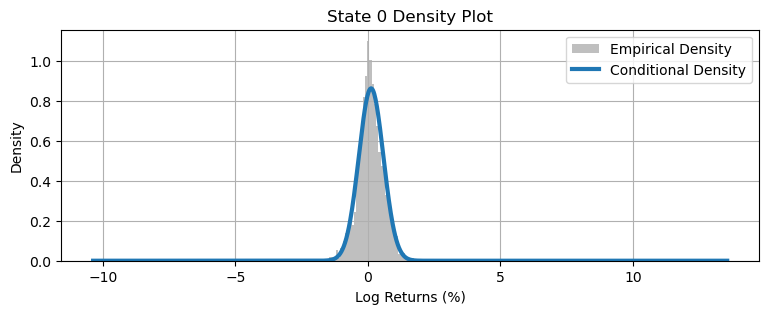

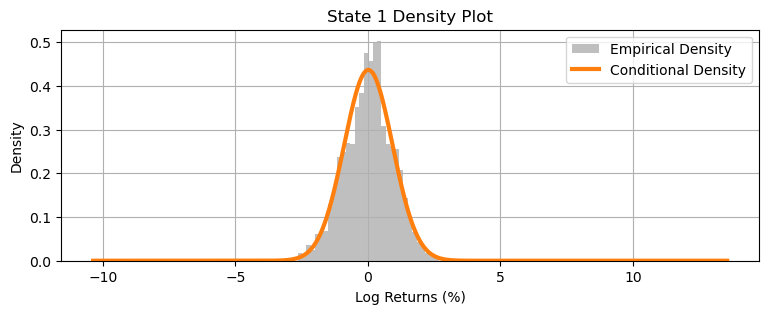

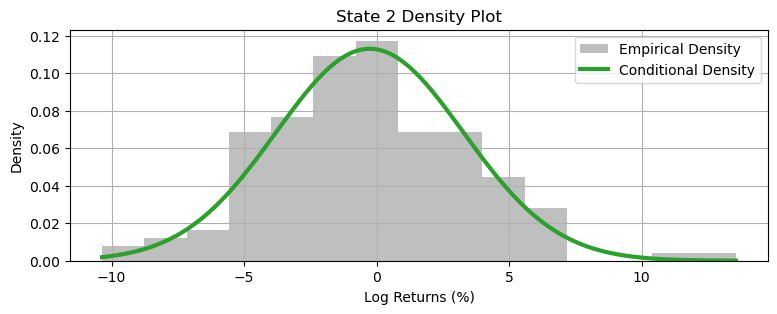

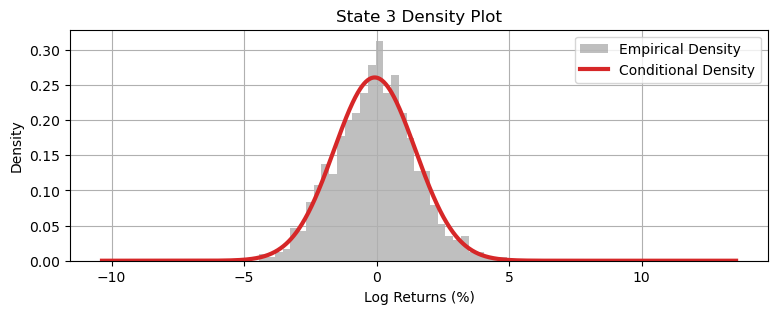

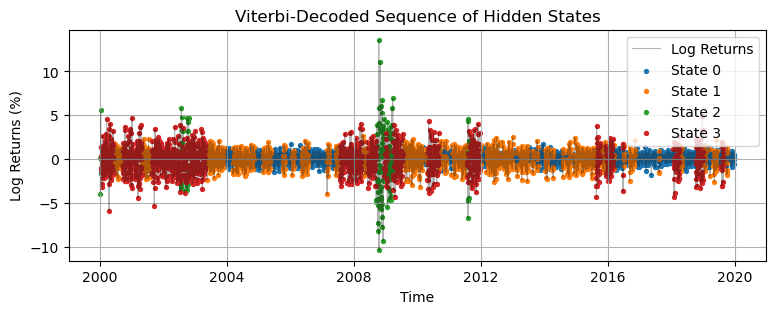

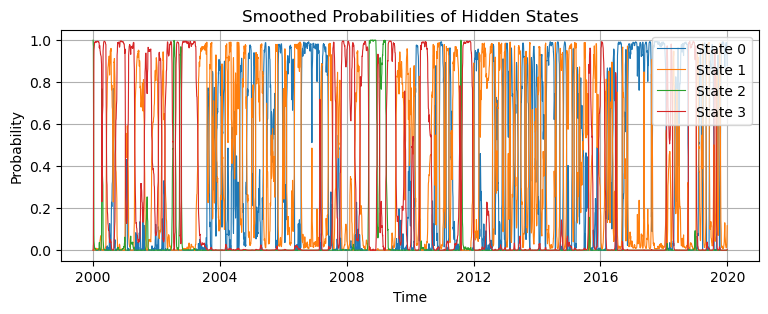

In [10]:
import src.plots.hmm_plots as plot

plot.plot_densities(hmm4, logret)
plot.plot_viterbi_seq(hmm4, logret)
plot.plot_probs(hmm4, logret)

## Benchmarking with Predictive Log Score

In [11]:
gaussian = models.Gaussian()
student_t = models.StudentT()
garch = models.GARCH()
benchmarks = [gaussian, student_t, garch]
for model in benchmarks: 
    model.fit(logret)

all_models = {
    '4-state HMM' : hmm4,
    'Gaussian' : gaussian,
    'Student_t' : student_t, 
    'GARCH(1,1)' : garch
}

print(f"{'Model':<12}{'AIC':>14}{'BIC':>14}{'Log-Score':>12}")
for name, model in all_models.items(): 
    print(f"{name:<12}" +
          f"{aic(model.loglik, model.n_params):14.6f}" +
          f"{bic(model.loglik, model.n_params, len(logret)):14.6f}", 
          end = ""
         )
    if name == '4-state HMM': 
        print(f"{model.log_predictive_density(logret_test, logret).mean():12.6f}")
    else:
        print(f"{model.log_predictive_density(logret_test).mean():12.6f}")

Model                  AIC           BIC   Log-Score
4-state HMM   13448.655263  13598.683721   -1.412108
Gaussian      16063.564270  16076.610223   -1.698296
Student_t     14663.971440  14683.540369   -1.522812
GARCH(1,1)    13673.569566  13699.661471   -1.326120
